# Same code as in the previous notebook:

In [ ]:
# Comment the following lines if you're not in colab:
# from google.colab import drive
drive.mount('/content/drive')
# If you're in colab, cd to your own working directory here:
%cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-4

In [ ]:
import matplotlib.pyplot as plt

import torch as tc
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchsummary import summary

In [ ]:
device = tc.device("cuda" if tc.cuda.is_available() else "cpu")
figsize_ = (3,3)

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self, n_classes=10):
        super(SimpleCNN, self).__init__()

        self.n_classes = n_classes

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            dilation=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            dilation=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=2,
            stride=1,
            padding=1,
            dilation=2
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )  # non-parametric, same object can be used

        self.fc1 = nn.Linear(
            in_features=64*3*3,
            out_features=32
        )
        self.fc2 = nn.Linear(
            in_features=32,
            out_features=self.n_classes
        )

    def forward(self, x):          # dimension analysis:
        x = F.relu(self.conv1(x))  # 1x28x28  --> 16x28x28
        x = self.pool(x)           # 16x28x28 --> 16x14x14
        x = F.relu(self.conv2(x))  # 16x14x14 --> 32x14x14
        x = self.pool(x)           # 32x14x14 --> 32x7x7
        x = F.relu(self.conv3(x))  # 32x7x7   --> 64x7x7
        x = self.pool(x)           # 64x7x7   --> 64x3x3
        x = x.view(-1, 64 * 3 * 3) # 64x3x3   --> 64*3*3
        x = F.relu(self.fc1(x))    # 64*3*3   --> 32
        x = self.fc2(x)            # 32       --> 10
        return x

In [ ]:
datapath = 'data'

data_train = MNIST(
    root = datapath,
    train = True,
    transform=  ToTensor(),
    download = True
)

digit.shape = torch.Size([1, 28, 28])


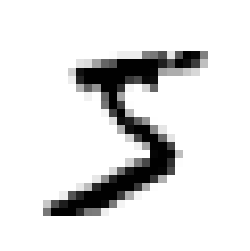

In [ ]:
digit, label = data_train[0]
digit = digit.to(device)
print(f"digit.shape = {digit.shape}")

plt.figure(figsize=figsize_)
plt.imshow(digit[0].cpu(), cmap='binary')
plt.axis('off')
plt.show()
plt.close()

In [ ]:
model = SimpleCNN(n_classes=10).to(device)
_ = summary(model=model, input_size=digit.shape)
out = model(digit)
print(f"out.shape = {out.shape}")

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            8,256
├─MaxPool2d: 1-4                         --
├─Linear: 1-5                            18,464
├─Linear: 1-6                            330
Total params: 31,850
Trainable params: 31,850
Non-trainable params: 0
out.shape = torch.Size([1, 10])


# <u> Visualize Features Extracted by Convolutional Layers </u>

One main advantage of using CNNs is that you can visualize the features that are extracted by convolutional layers. Convolutional layers extract local features from an image, such as edges, corners, etc. <br>
These can be visualized using e.g., the `plt.imshow()` function of the Matplotlib library. If you use the `'binary'` colormap, darker pixels show the parts of the picture that receive a higher "score" by the network. You can think of darker parts as the most relevant for the final model's prediction.

Let's create an instance of the previous model that we used and check that everything works fine so far:

We can load the weights that we trained from before:

In [ ]:
loaded_state_dict = tc.load("saved_models/CNN.pt")
model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

We will create a helper plotting function. We'll be plotting in grayscale, so, as the pixel values approach $-\infty$ they get blacker, and as they approach $+\infty$ they get whiter. Careful though, because the minimum pixel value will be set as the darkest for each instance.

In [ ]:
def plot_layer(out_features, features_per_row=8, vmin=-.5, vmax=.5):
    n_rows = len(out_features) // features_per_row
    n_tot = int(n_rows*features_per_row)
    out_features = out_features[:n_tot]
    fig = plt.figure(figsize=(features_per_row, n_rows))
    for i, out_ in enumerate(out_features):
        a = fig.add_subplot(n_rows, features_per_row, i+1)
        plt.imshow(out_, cmap='gray', vmin=vmin, vmax=vmax)
        a.axis("off")
plt.show()
plt.close()

We'll give the network as input this digit that we drew from the dataset. Then, let us visualize what the output from the first layer of our network looks like. The first layer has $16$ output channels and does not change the shape. So, we'll get a total of $16$ images, that are $28\times 28$ each.

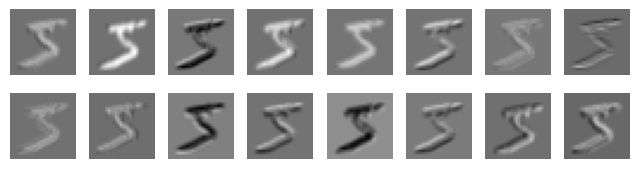

In [ ]:
out_conv1 = model.conv1(digit)

# Keep the initial min and max values for color comparison reference:
minv, maxv = out_conv1.min().item(), out_conv1.max().item()

plot_layer(out_conv1.cpu().detach().numpy(), vmin=minv, vmax=maxv)

These outputs are also called **feature maps** in literature. Next, let us see what the same outputs look like after being passed through ReLU. Since all negative values will be mapped to $0$, we should see a much "whiter" outcome:

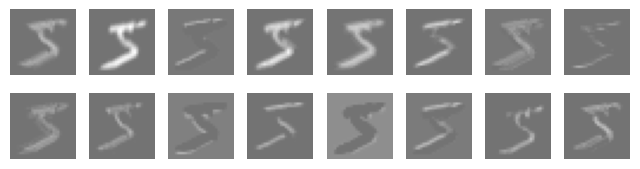

In [ ]:
out_relu1 = F.relu(out_conv1)
plot_layer(out_features=out_relu1.cpu().detach().numpy(), vmin=minv, vmax=maxv)

Let's see now the images we get from the output of the second convolutional layer of our network:

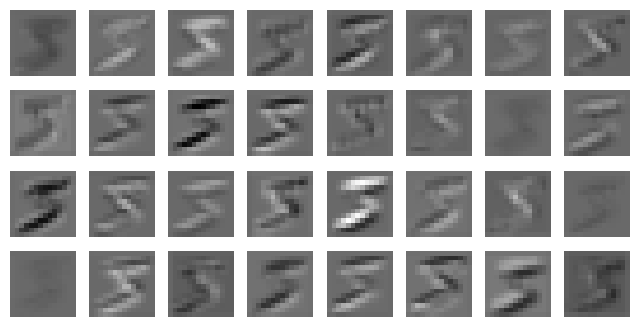

In [ ]:
out_pool1 = model.pool(out_relu1)
out_conv2 = model.conv2(out_pool1)
minv, maxv = out_conv2.min().item(), out_conv2.max().item()

# Keep the initial min and max values for color comparison reference:
plot_layer(out_features=out_conv2.cpu().detach().numpy(), vmin=minv, vmax=maxv)

And out of the ReLU:

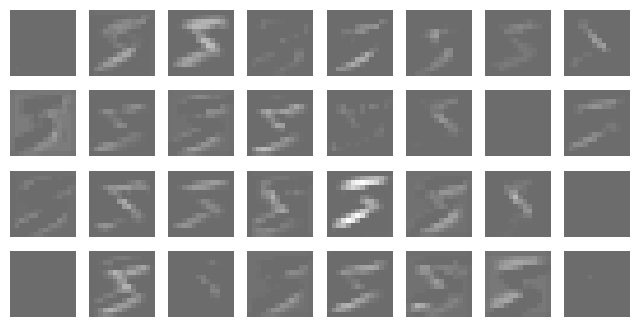

In [ ]:
out_relu2 = F.relu(out_conv2)
plot_layer(out_relu2.cpu().detach().numpy(), vmin=minv, vmax=maxv)

#<u>Homework (optional)</u>

-Do the same with the rest of the layers of the network. Does it stop being interpretable at some point?

-Visualizing the weights in a convolutional layer offers another method to gain insights into the types of features that the layer has learned to recognize. However, it's not always straightforward; some filters may be very difficult to interpret clearly regarding their specific function. Attempt to visualize the filters in the convolutional layers of this model. Do you get any insights in this case? One source you may find useful is: <br>
https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e